In [133]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf
from finta import TA    
from config import *
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

importing necessary libraries

In [134]:
def fetch_daily_data(symbol):
    """
    Fetches daily stock data for a given symbol over the last 5 years
    @return: pandas DF containing daily stock data
    """
    today = datetime.now().strftime("%Y-%m-%d")
    two_years_ago = (datetime.strptime(today, "%Y-%m-%d") - timedelta(days=2.5*365)).strftime("%Y-%m-%d")
    df = yf.download(symbol, start=two_years_ago, end=today)
    # df = yf.download([symbol], '2017-01-01', '2021-12-20')

    return df

    

In [140]:
df = fetch_daily_data('^GSPC')
df.columns = df.columns.droplevel(1) 
# plt.figure(figsize=(15,6))
# plt.title('MSFT Close Price History')
# plt.plot(df['Close'])
# plt.xlabel('Date')
# plt.ylabel('Close Price USD')
# plt.show();

[*********************100%***********************]  1 of 1 completed


In [142]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Engineer features from stock data
    @param df: pandas DF containing stock data
    @return: pandas DF containing engineered features
    '''

    df['SMA200'] = TA.SMA(df,200) # simple moving average over 100 days
    df['RSI'] = TA.RSI(df) # Relative Strength Index
    df['ATR'] = TA.ATR(df) # Average True Range
    df['BBWIDTH'] = TA.BBWIDTH(df) # Bollinger Bands Width
    df['Williams'] = TA.WILLIAMS(df) # Williams %R

    df = df.iloc[200:, :] # drop the first 200 rows since we are using 200 day SMA 
    df['Target'] = df.Close.shift(-1) # shift the closing price up one row to predict the next days closing price 
    df.dropna(inplace=True) # drop any rows with missing values
    return df

df = engineer_features(df)
df.tail()

/var/folders/cp/q2ltvsgx5dd856zr339ft0z40000gn/T/ipykernel_58258/3170866804.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = df.Close.shift(-1) # shift the closing price up one row to predict the next days closing price
/var/folders/cp/q2ltvsgx5dd856zr339ft0z40000gn/T/ipykernel_58258/3170866804.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True) # drop any rows with missing values


Price,Close,High,Low,Open,Volume,SMA200,RSI,ATR,BBWIDTH,Williams,Target
Date,,,,,,,,,,,
2025-04-10,5268.049805,5353.149902,5115.270020,5353.149902,6677140000,5754.785046,40.605356,215.010010,0.176567,-54.511488,5363.359863
2025-04-11,5363.359863,5381.459961,5220.770020,5255.560059,5602550000,5754.255347,44.208056,218.803571,0.177997,-44.498982,5405.970215
2025-04-14,5405.970215,5459.459961,5358.020020,5441.959961,5031440000,5753.895698,45.791169,224.154262,0.177171,-39.812127,5396.629883
2025-04-15,5396.629883,5450.410156,5386.439941,5411.990234,4317110000,5753.464497,45.486481,222.351423,0.177274,-37.409166,5275.700195
2025-04-16,5275.700195,5367.240234,5220.790039,5335.750000,4607750000,5752.540598,41.624768,230.529994,0.178392,-48.776530,5282.700195


#### Simple Moving Average - 100 day 
- Purpose: shows the overall trend over the past 100 days 
- Use in ML:
- Helps model understand if stock is long-term moving upwards or downwards


#### Relative Sitrength Index 
- Purpose: measures momentum - how strongly a stock has moved up or down recently on a 0-100 scale
- Use in ML:
- helps detect potential reversal points or trend exhaustion


#### Average True Range 
- Purpose: measures volatility - how much the price has been fluctuating
- Use in ML:
- Helps capture risk level of a stock 
- Useful for adjusting predictions based on user risk tolerance 


#### Bollinger Band Width 
- Purpose: measures the width Bollinger Bands which expand/contract based on volatility - wider = higher volatility
- Use in ML:
- can indicate a trend change



#### Williams %R
- Purpose: measures overbought/oversold conditions on scale of -100 to 0 
- Closer to 0 is overbought 
- Use in ML
- Good for identifying potential entry or exit points
- Often used with RSI to confirm signals
---
- the target column is created by shifting columns up one
- it essentially makes the next days closing price today's target

In [137]:
def train_test_split(data: pd.DataFrame,perc: float) -> tuple[np.ndarray, np.ndarray]:
    '''
    Splits data into train and test sets
    @param data: pandas DF containing stock data
    @param perc: percentage of data for test set
    @return: train set, test set
    '''

    ret = data.values
    n = int(len(data) *  (1-perc)) 
    return ret[:n], ret[n:]

In [138]:
train, test = train_test_split(df,.7)
train

array([], shape=(0, 12), dtype=float64)

In [139]:
print(len(df))
print(len(train))
print(len(test))
train[0,:-1] # first row without the last column (target)


0
0
0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [115]:
X = train[:,:-1] # all features/input variables except last column (target) - info used to predict target
y = train[:,-1] # contains only the target values (stock price trying to predict)
# overall this code separates the features and target values from the ds to train the model 
y

array([319.66424561, 317.51367188, 316.74258423, 313.26278687,
       312.86730957, 318.20568848, 318.77905273, 323.26724243,
       316.31747437, 319.29312134, 320.00491333, 324.66116333,
       325.0368042 , 324.01861572, 324.9083252 , 329.74246216,
       329.08016968, 326.14404297, 330.45422363, 334.08236694,
       327.98275757, 332.22381592, 334.8336792 , 326.45050049,
       325.30374146, 324.89840698, 317.10830688, 315.88250732,
       313.3913269 , 313.91525269, 308.57687378, 309.21948242,
       310.05978394, 312.1456604 , 318.12658691, 309.81268311,
       315.31903076, 315.7144165 , 323.52429199, 326.05502319,
       324.64141846, 328.62542725, 327.37973022, 323.98895264,
       328.84286499, 328.26947021, 326.34173584, 327.53796387,
       322.94104004, 325.5607605 , 326.75692749, 336.78121948,
       324.14709473, 326.04516602, 333.45956421, 334.25042725,
       342.11959839, 344.34390259, 348.7727356 , 352.46014404,
       356.41452026, 359.05404663, 356.57269287, 365.45

In [116]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV


# params = {
#     'max_depth': [3,6], # determines the max depth of each tree in the model 
#     'learning_rate': [0.05], # controls the step size in each boosting iteration which prevents overfitting
#     'n_estimators': [700,1000], # number of trees in the model
#     'colsample_bytree': [0.3, 0.7], # determines the fraction of features to randomly sample for each tree, helps prevent overfitting
# }

# # The learning rate is a key hyperparameter that determines how much each new tree added to the model contributes to the overall prediction
# # It acts as a scaling factor for the corrections made by each successive tree in the boosting process

# # How it works:
# # Sequential Learning: trees are added one at a time each aiming to correct the errors (residuals) of the existing ensemble
# # The learning rate multiplies the output of each new tree before adding it to the ensemble 
# # A learning rate of 1.0 means each tree's corrections are fully applied 
# # Values less than 1 reduce the impact of each tree - making the model learn more slowly and cautiously 
# # Lower Learning Rate -- model learns slower, requires more trees, prevents overfitting, training takes longer 


# # XGBoost Regressor is a type of gradient boosting model that build trees one at a time, each tree is trained
# # to correct the errors of the previous tree by focusing on the examples that were misclassified 
# # the model then combines the predictions of all trees to make a final prediction
# # gradient boosting is a technique that build an ensemble of weak models to create a strong predictive model
# xgbr = XGBRegressor(seed = 20) # initalize the model 


# # GridSearchCV is used to find the best parameters for the model by searching through a grid of parameters
# # take xgbr model, params, neg_mean_sqaured error as the scoring metric, verbose = 1 for detailed output
# # the scoring is neg_mean_squared_error which is the average of the squared differences between the predicted and actual values
# # this metric penalizes large errors more heavily which helps the model focus on minimizing large errors
# # the verbose works to print the best parameters and the lowest RMSE 
# modl = GridSearchCV(estimator=xgbr, param_grid=params, scoring = 'neg_mean_squared_error', verbose=1)
# modl.fit(X, y) # fit the model 


# print('Best Parameters:', modl.best_params_)
# print('Lowest RMSE:', (-modl.best_score_)**(1/2.0))
# # the model.best_params_ is the best parameters found by grid search
# # best parameters are the ones that result in the lowest RMSE 

In [ ]:
# this is the model that will be used to make predictions
# the objective is to minimize the error between the predicted and actual values
# reg means regression and squarederror is the loss function 
# gamma is the minimum loss reduction required to make a further partition on a leaf node of the tree
model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 750, colsample_bytree = 0.7, learning_rate = 0.05, max_depth = 3, gamma = 1)
model.fit(X,y) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=750, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [118]:
test[0,:] # this accesses the first row of the test set 

array([ 4.11352936e+02,  4.16781357e+02,  4.10847725e+02,  4.16603057e+02,
        2.12029000e+07,  3.42316858e+02,  6.47100585e+01,  7.22070408e+00,
        8.40324326e-02, -2.35494761e+01,  4.02497070e+02])

In [119]:
val = np.array(test[0,:-1]).reshape(1,-1) # this line converts the first row of the test set into a numpy array and reshapes it into a 1x-1 array 
pred = model.predict(val) # this line uses the model to make a prediction on the first row of the test set 
pred

# first it takes the first row of the test data and removes the last column (target)
# then it reshapes the resulting array into a 2D array with 1 row 
# this array represents the features of stock data for a particular day
# next it uses the trained model to make a prediction on this day's features 
# the predict function takes the reshaped array and returns the predicted value 

array([414.43488], dtype=float32)

In [120]:
def xgb_predict(train: pd.DataFrame, val: pd.DataFrame) -> float:
    '''
    # Predicts closing price of stockusing XGBoost Regressor 
    @param train: pandas DF containing training data 
    @param val: pandas DF as a validation set 
    @return: float prediction

    ---
    - First the training data is converted to a numpy array 
    - Then the features and target values are separated 
    - Then the model is initialized and trained on the training data 
    - Then the validation set is converted to a numpy array and reshaped into a 2D array with 1 row
    - Then the model is used to make a prediction on the validation set 
    - The prediction is then returned as a float
    '''
    train = np.array(train)
    X, y = train[:,:-1], train[:,-1]
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.7, max_depth =3, gamma = 1)
    model.fit(X,y)
    val = np.array(val).reshape(1,-1)
    pred = model.predict(val)
    return pred[0]

In [ ]:
# using the xgb_predict function 
# passing in the training data and the first row of the test data 
# the goal is to used the trained model to predict the closing price of the stock for the first row of the test data 
xgb_predict(train, test[0, :-1])


414.43488

In [122]:
def mape(actual, pred) -> float:
    ''' 
    Calculates the mean absolute percentage error between the actual and predicted values 
    @param actual: array containing actual values 
    @param pred: array containing predicted values
    @return: float mape
    '''
    actual = np.array(actual)
    pred = np.array(pred)
    mape = np.mean(np.abs((actual - pred) / actual) * 100)
    return mape 


In [123]:
from sklearn.metrics import root_mean_squared_error

def validate(data, perc):
    '''
    Validates the model by predicting the closing price of the stock for each day in the test set 
    @param data: df containing stock data 
    @para perc: percentage of data for test set 
    @return: float error, float MAPE, array of actual targetvalues, array of predicted values
    '''
    predictions = []
    train, test = train_test_split(data, perc)
    # data is split into training and testing sets 
    history = [x for x in train] # history is a list of the elements in the training set 


    # for loop iterates over each element in the testing set 
    # for each iteration, the input features (X_test) and target value (y_test) are extracted from the test set 
    # the xgb_predict function is then called to predict the target value using the history the history data 
    # the predicted value is then added to the predictions list  
    for i in range(len(test)):
        X_test, y_test = test[i,:-1], test[i,-1]
        pred = xgb_predict(history, X_test)
        predictions.append(pred)

        history.append(test[i])

    # the mean squared error is calculated between the actual target values and predicted values 
    error = root_mean_squared_error(test[:,-1], predictions)

    # the mape is calculated between the actual and predicted values 
    MAPE = mape(test[:,-1], predictions)


    return error, MAPE, test[:,-1], predictions

In [124]:
rmse, MAPE, y, pred = validate(df, 0.7)

In [125]:
print("RMSE:", f'{rmse}')
print("MAPE:", f'{MAPE}')
print(y)
print(pred)

RMSE: 6.933104918073839
MAPE: 1.2605380429541917
[402.49707031 406.38735962 403.47958374 400.99853516 399.73812866
 399.13275146 408.53097534 407.23095703 404.45217896 404.39260864
 404.63076782 410.50595093 412.35183716 411.77627563 399.59915161
 399.04342651 406.04006958 403.14215088 401.45501709 412.13348389
 411.95489502 421.99819946 413.26489258 414.15805054 418.21707153
 422.00811768 426.11672974 425.49151611 419.65606689 418.45523071
 418.23687744 417.5322876  421.3531189  418.24685669 417.26434326
 414.71380615 422.29592896 421.37295532 423.05014038 420.05307007
 424.68768311 418.70336914 410.50595093 411.43881226 408.71957397
 401.20690918 396.09594727 397.92199707 404.48193359 405.96060181
 396.01654053 403.24139404 399.20220947 386.38009644 391.94760132
 394.82565308 403.57879639 410.40670776 406.23852539 407.42944336
 409.19592285 411.5975647  410.58532715 413.40380859 420.63174438
 418.55383301 417.77832031 422.87866211 426.55725098 428.02871704
 424.52905273 427.67077637 

In [126]:
# takes the predicted values from the model and converts them into a numpy array
pred = np.array(pred)

# then it combines these predicted values with the actual target values from the test set 
# the numpy.c_ function allows us to see the predicted values alongside the actual target values
test_pred = np.c_[test, pred]

In [127]:
df_TP = pd.DataFrame(test_pred, columns = ["Close",	"High",	"Low",	"Open",	"Volume",	"SMA200" ,"RSI",	"ATR",	"BBWIDTH",	"Williams",	"Target", "Pred"])

In [128]:
# adds the date column to the dataframe
df = df.reset_index(names='Date')

# Extract only the Date and Target from df
df_dates = df[['Date', 'Target', 'Close']]

# Merge df_TP with df_dates on the Target column
df_TP = pd.merge(df_TP, df_dates, on='Target', how='left')

# sort dataframe by date 
df_TP = df_TP.sort_values(by='Date').reset_index(drop=True)

Text(0, 0.5, 'Price USD')

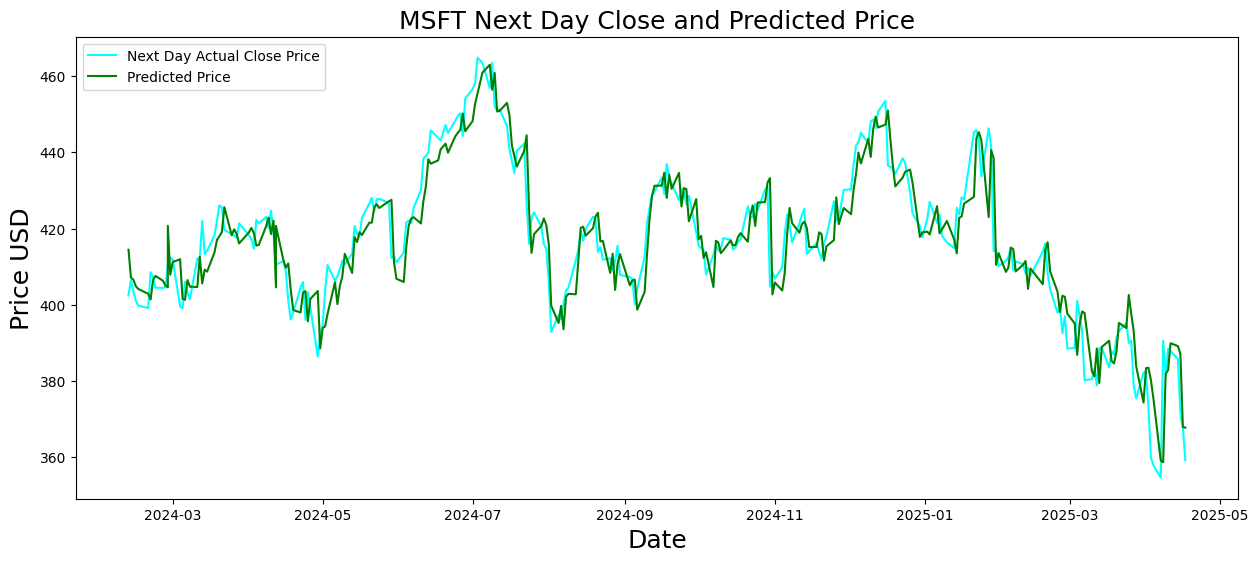

In [ ]:
plt.figure(figsize = (15,6))
plt.title("MSFT Next Day Close and Predicted Price", fontsize = 18)
plt.plot(df_TP['Date'],df_TP['Target'], label = 'Next Day Actual Close Price', color = 'cyan')
plt.plot(df_TP['Date'], df_TP['Pred'], label = 'Predicted Price', color = 'green', alpha = 1)
plt.xlabel('Date',fontsize = 18)
plt.legend(loc = 'upper left')
plt.ylabel('Price USD', fontsize = 18)